In [2]:
# import...
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import math
import numpy as np
from matplotlib.dates import DateFormatter

os.chdir("/Users/etmu9498/research/code/scripts-winter2023")
import helper_fns_winter2023 as helper_fns

TC track added
20210925H1_sam.nc flight path added
34354
29941
20210926H1_sam.nc flight path added
34872
30481
20210927I1_sam.nc flight path added
25535
22981
20210927H1_sam.nc flight path added
32266
28321
20210929H1_sam.nc flight path added
34804
30421
20210929H2_sam.nc flight path added
34028
28921


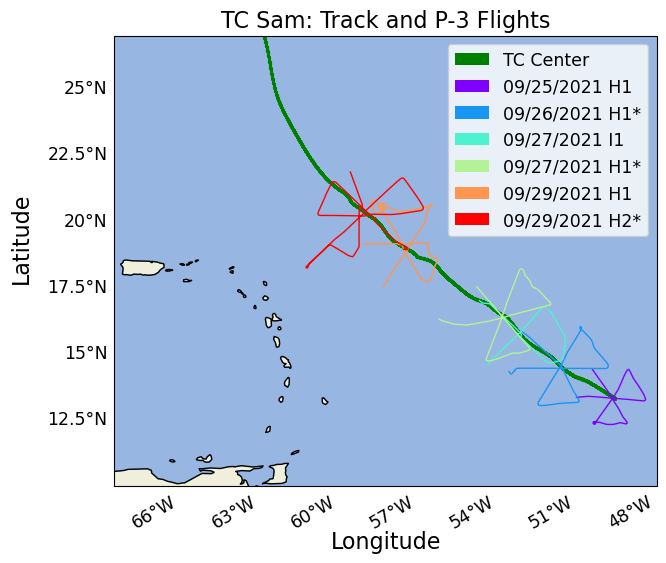

In [3]:
# make a line plot for every tc track to check out the spatial coverage of sam!

# make the figure before the loop
fig = plt.figure( figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
helper_fns.change_font_sizes(16, 16)

# make the figure look nicer
ax.set_extent([-67.5, -47, 10, 27], crs=ccrs.PlateCarree())
gl = ax.gridlines( draw_labels=True, color="k")
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN) # , facecolor='#90cfff')
ax.add_feature(cfeature.COASTLINE)
ax.set_title( "TC Sam: Track and P-3 Flights")
ax.text(-0.15, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)
gl.xlabel_style = {'rotation': 30, 'fontsize': 12.5}
gl.ylabel_style = {'fontsize': 12.5}


# add the track of the tc! load the track file first
track_file_path = "/Users/etmu9498/research/data/track/"
track_name = 'sam2021.trak'
col_names = ['date', 'time (UTC)', 'lat', 'lat dir', 'lon', 'lon dir']
track_data = pd.read_fwf( track_file_path + track_name, skiprows=3, names = col_names)
# adding the track!
proj = ccrs.PlateCarree()
tracklat = track_data.lat
tracklon = - track_data.lon   
img2 = ax.scatter( tracklon, tracklat, c = 'g', transform= proj, s= 1.5, marker='o' )
print( 'TC track added')

# add each fl case from the fl_list below
fl_list = [ '20210925H1_sam.nc', '20210926H1_sam.nc', '20210927I1_sam.nc', '20210927H1_sam.nc', 
           '20210929H1_sam.nc', '20210929H2_sam.nc']
# used to specify crl datasets!
star_case = [ "", "*", "", "*", "", "*"]

# use separate cutoff inds to make flight paths look pretty!
lim0 = [ 16500, 14500, 12000, 12000, 11250, 12000]
lim1 = [ 10500, 10000, 7000, 9500, 12000, 5500]


# colors = ['r', 'b', 'k', 'forestgreen', 'dimgray', 'coral']
# colors = [mcolors.to_rgba(f"black", alpha=i/10 + .4) for i in range(6)]
cmap = plt.cm.get_cmap( "rainbow") # "YlOrRd")
colors = []
for i in range( len( fl_list)):
    colors.append( cmap(i/5))

for tci, tcval in enumerate( fl_list):
    if tci < 6:
        # load flight level data for this case!
        os.chdir( "/Users/etmu9498/research/data/in-situ-noaa-full/2021/")
        fl_data = xr.open_dataset( tcval, decode_times=False)
        # fl_data = xr.open_dataset( tcval[:-3] + "_processed.nc", decode_times=False)

        fllat = fl_data.LATref[lim0[tci] : len(fl_data.LATref) - lim1[tci]]
        fllat = fllat[::50]
        fllon = fl_data.LONref[lim0[tci] : len(fl_data.LONref) - lim1[tci]]
        fllon = fllon[::50]  
        fltrack = sgeom.LineString(zip(fllon, fllat))
        
        ax.add_geometries([fltrack], ccrs.PlateCarree(),
                          facecolor='none', edgecolor = colors[ tci])                          
        print( tcval + " flight path added")

        print( len( fl_data.LATref) - 1500)
        print( len( fl_data.LATref[ np.where( ~ np.isnan( fl_data.LATref))[0] ]))
    
# add a legend separately after plotting
r = [ mpatches.Rectangle((0, 0), 1, 1, facecolor="g")]
labels = ['TC Center']
# loop through data and add legend labels
for casei, val in enumerate( fl_list):
    r.append( mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[ casei]))
    # create a nice label from given date!
    labels.append( val[4:6] + '/' + val[6:8] + '/' + val[0:4] + ' ' + val[8:10] + star_case[casei])


ax.legend( r, labels, loc='upper right', fontsize=12.5)    
# plt.show()

os.chdir("/Users/etmu9498/research-private/colloquium")
plt.savefig("track-and-flights.png", dpi=250, bbox_inches='tight')

In [3]:
# setup for making an intensity plot from ships environmental data!

# load the full ships dataset
print( "Loading SHIPS dataset")
os.chdir(  "/Users/etmu9498/research/data/ships/")
file1 = open('lsdiaga_1982_2021_sat_ts_5day.txt', 'r')
Lines = file1.readlines()
# there are a bunch of lines in the total ships file!!
print( "SHIPS dataset created")
print( "Number of lines in dataset: " + str( len( Lines)))

# manually enter metadata
year = '2021'
strname = 'SAM'
fl_name = '20210925H1_sam_processed.nc'
ri_cond = 30
fl_path = "/Users/etmu9498/research/data/in-situ-noaa-processed/" + year
os.chdir( fl_path)
data = xr.open_dataset( fl_name)


# convenient x axis variables for plotting
time_since_start = []
datetimes = [] # save datetime objects here
date_only = [] # save MM/DD strings for nicer date representations below

# useful y axis variables
vmax = []
psurf = []
startdate = 0
starttime = 0

# go through all the lines to find indices 
header_inds = []
for ind in range( len( Lines)):
    # get the heading lines, and look for this TC's cases!
    if 'HEAD' and strname  in Lines[ ind]:
        # only keep 2021 cases
        if Lines[ ind][ 6 : 8] == str( year[ 2:4]):
            header_inds.append( ind)
            
# search through all headers and append useful plotting info like current time, date, etc
for headeri, headerval in enumerate( header_inds):    
    # add times to the list! increments of 6 hours
    if headeri == 0:
        time_since_start.append( 0)
        # append starting dates and times
        for i in range( headerval,  len( Lines) ):
            if 'HEAD' in Lines[ i]:
                startdate = Lines[i][6:12]
                starttime = Lines[i][13:15]
                break
        print( 'start date and time updated')
    else:
        # otherwise, find the most recent time and add 6 hours!
        time_since_start.append( time_since_start[-1] + 6)

    # add datetime objects!
    for i in range( headerval,  len( Lines) ):
        if 'HEAD' in Lines[ i]:
            month = int( Lines[i][8:10] )
            day = int( Lines[i][10:12] )
            hours = int( Lines[i][13:15] )
            datetime_orig = datetime.datetime( int( year), month, day, hours, 0, 0)
            datetimes.append( datetime_orig) # datetime_orig.strftime( "%m/%d %H %M %S"))
            date_only.append( str( datetime_orig.strftime( "%m/%d")))
            break
    # search for vmax!
    for i in range( headerval,  len( Lines) ):
        if 'VMAX' in Lines[i]:
            vmax.append( int( Lines[i][12 : 15]) ) # the last 3 vals for vmax at 0 hours
            break
    # repeat for pressure
    for i in range( headerval,  len( Lines) ):
        if 'MSLP' in Lines[i]:
            psurf.append( int( Lines[i][11:15] )  ) # the last 3 vals for vmax at 0 hours
            break
            
print( "starting date: " + str( startdate))
print( "starting time: " + str( starttime))
print( "hours from start time: " + str( np.max( np.array( time_since_start))))

# trim down datetimes and vmaxes to these limits for more concise plotting
i0 = 5
i1 = 34
datetimes = datetimes[ i0:i1]
date_only = date_only[ i0:i1]
vmax = vmax[ i0:i1]
psurf = psurf[ i0:i1]


Loading SHIPS dataset
SHIPS dataset created
Number of lines in dataset: 1884145
start date and time updated
starting date: 210922
starting time: 18
hours from start time: 294


6
0: 2021-09-24 00:00:00
1: 2021-09-24 06:00:00
2: 2021-09-24 12:00:00
3: 2021-09-24 18:00:00
4: 2021-09-25 00:00:00
5: 2021-09-25 06:00:00
6: 2021-09-25 12:00:00
7: 2021-09-25 18:00:00
8: 2021-09-26 00:00:00
9: 2021-09-26 06:00:00
10: 2021-09-26 12:00:00
11: 2021-09-26 18:00:00
12: 2021-09-27 00:00:00
13: 2021-09-27 06:00:00
14: 2021-09-27 12:00:00
15: 2021-09-27 18:00:00
16: 2021-09-28 00:00:00
17: 2021-09-28 06:00:00
18: 2021-09-28 12:00:00
19: 2021-09-28 18:00:00
20: 2021-09-29 00:00:00
21: 2021-09-29 06:00:00
22: 2021-09-29 12:00:00
23: 2021-09-29 18:00:00
24: 2021-09-30 00:00:00
25: 2021-09-30 06:00:00
26: 2021-09-30 12:00:00
27: 2021-09-30 18:00:00
28: 2021-10-01 00:00:00
[datetime.datetime(2021, 9, 27, 0, 0), datetime.datetime(2021, 9, 28, 0, 0), datetime.datetime(2021, 9, 30, 0, 0)]


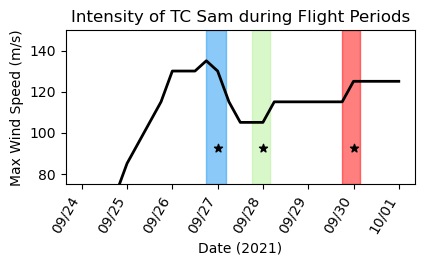

In [4]:
# make a nice intensity plot! show pressure and vmax

# choose the plot type: either 'crl' which only shows crl data, or 'full' which shows all data
plot_type = 'crl'

# make the figure
if plot_type == 'full':
    fig, ax = plt.subplots(1, 1, figsize=(5, 2.5)) 
    fs=12
else:
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 2)) 
    fs=12
helper_fns.change_font_sizes( fs, fs)
lw = 2
n = 4  # Keep every 4th date label

# add nice axis labels and add the wind speed plot!
ax.set_title( "Intensity of TC Sam during Flight Periods", fontsize= fs)
ax.set_xlabel( "Date (2021)")
ax.set_ylabel( "Max Wind Speed (m/s)")
plt.xticks(rotation=60, ha="right")
ax.plot( datetimes, vmax, c='k', linewidth=lw)

# get plot colors
cmap = plt.cm.get_cmap( "rainbow") # "YlOrRd")
colors = []
for i in range( 6):
    colors.append( cmap(i/5))
    
print(len(colors))

#############
# plot vertical lines on main plot signifying locations of P-3 flights! at median time
#############
# add each fl case- taken from spatial plot above
if plot_type == 'full':
    fl_list = [ '20210925H1_sam_processed.nc', '20210926H1_sam_processed.nc', '20210927I1_sam_processed.nc', '20210927H1_sam_processed.nc', 
               '20210929H1_sam_processed.nc', '20210929H2_sam_processed.nc']
    ax.set_ylim( [40, 140])
else:
    # do this when only showing crl data!
    fl_list = [ '20210926H1_sam_processed.nc', '20210927H1_sam_processed.nc', '20210929H2_sam_processed.nc']
    slice=[1, 3, 5]
    colors = list(np.array(colors)[slice])
    ax.set_ylim([75, 150])


# add pressure data to the plot!
if plot_type == 'full':
    ax2 = ax.twinx()
    ax2.plot( datetimes, psurf, c='b', linewidth=lw)
    ax2.set_ylabel( "Min Surface Pressure (hPa)", c='b')
    ax2.yaxis.label.set_color('b')
    

# find the median times and convert them to datetimes
for fli, flval in enumerate( fl_list):
    # load current dataset
    os.chdir( "/Users/etmu9498/research/data/in-situ-noaa-processed/2021/")
    fl_data = xr.open_dataset( flval, decode_times=False)

    # make vertical bars representing timespans of flights!
    start, end = fl_data.time[0].values, fl_data.time[-1].values
    remainder_min_start, remainder_min_end = ( start - math.floor( start) ) * 60, ( end - math.floor( end) ) * 60
    remainder_sec_start, remainder_sec_end = ( remainder_min_start - math.floor( remainder_min_start)) * 60, ( remainder_min_end - math.floor( remainder_min_end)) * 60
    # get the median time from hours (decimal) into datetime format for plotting!
    month = int( flval[4:6] )
    startday = int( flval[6:8] )
    starthours, endhours = math.floor( start), math.floor( end) # round down the median hour val
    # wraparound case
    if endhours > 23:
        endhours = endhours - 24
        endday = startday + 1
    else:
        endday = startday
    startminutes, endminutes = math.floor( remainder_min_start), math.floor( remainder_min_end)
    startseconds, endseconds = round( remainder_sec_start), round( remainder_sec_end)
    startdt = datetime.datetime( int( year), month, startday, starthours, startminutes, startseconds)
    enddt = datetime.datetime( int( year), month, endday, endhours, endminutes, endseconds)
    ax.axvspan( startdt, enddt, color= colors[fli], alpha=.5 )

    
# change the datetime format on the x axis to just dates
myFmt = DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(myFmt)

# add stars signifying crl datasets!
for dti, dt in enumerate(datetimes):
    print( str(dti) + ": " + str(dt))    
trimvals = [12, 16, 24]
dt_trim = list( np.array(datetimes)[trimvals])
print(dt_trim)
ax.scatter( dt_trim, [92.5, 92.5, 92.5], marker='*', c='k')

os.chdir("/Users/etmu9498/research-private/colloquium")
plt.savefig("intensity-" + plot_type + ".png", dpi=250, bbox_inches='tight')

In [ ]:
# old code
# don't both calculating median times; make spanning times for whole flight below!
'''
# calculate the median time here! 
median = (fl_data.time[-1].values + fl_data.time[0].values) / 2
remainder_min = ( median - math.floor( median) ) * 60
remainder_sec = ( remainder_min - math.floor( remainder_min)) * 60

# get the median time from hours (decimal) into datetime format for plotting!
month = int( flval[4:6] )
day = int( flval[6:8] )
hours = math.floor( median) # round down the median hour val
minutes = math.floor( remainder_min)
seconds = round( remainder_sec)
datetime_orig = datetime.datetime( int( year), month, day, hours, minutes, seconds)

# plot this median time on the intensity plot
# ax.axvline( x= datetime_orig, c=colors[fli], linewidth = lw)
'''
